In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.manifold
import collections

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC

import joblib

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка очищенных данных

In [2]:
df = pd.read_csv('clean_min_docs.csv')

In [3]:
df

,Unnamed: 0,Unnamed: 0.1,label,url,text,len in symbols,len in words
0,0,0,0,http://arbitrsamara.ru/dogovor-arendy/obespech...,связь правило высокий стоимость имущество пере...,215,28
1,1,1,0,http://inlobnya.ru/novosti/obrazovanie/vospita...,быть правительство брать обязанность выплачива...,181,26
2,2,2,0,http://marslanov.com/otzyvy/audit-kompanii-22-...,затем потребоваться снять крупный сумма начать...,329,49
3,3,3,0,http://mail.mycompany.su/RU/dinskaya/company/m...,каждый фирма рубрика услуга микрофинансировани...,128,18
4,4,4,1,https://ok.ru/ksfirst/topic/70000727225755,минимальный пакет документ минимальный_пакет п...,29,3
...,...,...,...,...,...,...,...
1099,1099,1099,0,http://citylife-spb.ulcraft.com/,наш фирма лидер рынок свой область наш_фирма ф...,44,9
1100,1100,1100,1,https://ok.ru/avtolombards/topic/69818751358246,получение заём клиент должный предоставить мин...,147,17
1101,1101,1101,0,http://etprf.ru/NotificationEX/id/109593,поставка оборудование эквайринг предоставление...,555,63
1102,1102,1102,0,http://customsforum.ru/citizens/auto-parts/,случай непредставление соответствующий докумен...,342,34


In [4]:
df.pop("Unnamed: 0")
df.pop("Unnamed: 0.1")

0          0
1          1
2          2
3          3
4          4
        ... 
1099    1099
1100    1100
1101    1101
1102    1102
1103    1103
Name: Unnamed: 0.1, Length: 1104, dtype: int64

In [5]:
df

,label,url,text,len in symbols,len in words
0,0,http://arbitrsamara.ru/dogovor-arendy/obespech...,связь правило высокий стоимость имущество пере...,215,28
1,0,http://inlobnya.ru/novosti/obrazovanie/vospita...,быть правительство брать обязанность выплачива...,181,26
2,0,http://marslanov.com/otzyvy/audit-kompanii-22-...,затем потребоваться снять крупный сумма начать...,329,49
3,0,http://mail.mycompany.su/RU/dinskaya/company/m...,каждый фирма рубрика услуга микрофинансировани...,128,18
4,1,https://ok.ru/ksfirst/topic/70000727225755,минимальный пакет документ минимальный_пакет п...,29,3
...,...,...,...,...,...
1099,0,http://citylife-spb.ulcraft.com/,наш фирма лидер рынок свой область наш_фирма ф...,44,9
1100,1,https://ok.ru/avtolombards/topic/69818751358246,получение заём клиент должный предоставить мин...,147,17
1101,0,http://etprf.ru/NotificationEX/id/109593,поставка оборудование эквайринг предоставление...,555,63
1102,0,http://customsforum.ru/citizens/auto-parts/,случай непредставление соответствующий докумен...,342,34


In [6]:
#очищенные предложения (список списков)
sentences = list(df['text'])

In [7]:
sentences 

['связь правило высокий стоимость имущество передаваемый длительный срок временной владение пользование арендатор условие обеспечительный платёж договор аренда включаться достаточно часто связь_правило правило_высокий высокий_стоимость стоимость_имущество имущество_передаваемый передаваемый_длительный длительный_срок срок_временной временной_владение владение_пользование пользование_арендатор арендатор_условие условие_обеспечительный обеспечительный_платёж платёж_договор договор_аренда аренда_включаться включаться_достаточно достаточно_часто',
 'быть правительство брать обязанность выплачивать стоимость квартира первоначальный взнос тело кредит участник оставаться платить процент быть_правительство правительство_брать брать_обязанность обязанность_выплачивать выплачивать_стоимость стоимость_квартира квартира_первоначальный первоначальный_взнос взнос_тело тело_кредит кредит_участник участник_оставаться оставаться_платить платить_процент',
 'затем потребоваться снять крупный сумма начать

##  2. Векторное представление текстов с помощью Doc2Vec

### 2.1. Построение векторов текстов

In [8]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [9]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentences)]

In [10]:
documents

[TaggedDocument(words='связь правило высокий стоимость имущество передаваемый длительный срок временной владение пользование арендатор условие обеспечительный платёж договор аренда включаться достаточно часто связь_правило правило_высокий высокий_стоимость стоимость_имущество имущество_передаваемый передаваемый_длительный длительный_срок срок_временной временной_владение владение_пользование пользование_арендатор арендатор_условие условие_обеспечительный обеспечительный_платёж платёж_договор договор_аренда аренда_включаться включаться_достаточно достаточно_часто', tags=[0]),
 TaggedDocument(words='быть правительство брать обязанность выплачивать стоимость квартира первоначальный взнос тело кредит участник оставаться платить процент быть_правительство правительство_брать брать_обязанность обязанность_выплачивать выплачивать_стоимость стоимость_квартира квартира_первоначальный первоначальный_взнос взнос_тело тело_кредит кредит_участник участник_оставаться оставаться_платить платить_проце

In [11]:
%%time
max_epochs = 100
vec_size = 256
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm = 0)
  
model.build_vocab(documents)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(documents,
                total_examples=model.corpus_count,
                epochs=model.iter)
    model.alpha -= 0.0002
    model.min_alpha = model.alpha

model.save("doc2vec_dbow.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [12]:
model.docvecs[0] #вектор первого предложения

array([-2.09621489e-01,  1.60663992e-01, -2.27712065e-01, -1.47279678e-02,
       -8.77317265e-02,  1.12420462e-01, -7.91685134e-02, -6.00379482e-02,
        4.15122360e-02, -1.97861791e-01, -2.17229903e-01, -8.54821876e-03,
       -3.81237417e-02, -2.74656564e-02,  1.33773357e-01, -2.19460040e-01,
        1.97259068e-01, -1.75464779e-01,  2.24728152e-01, -8.51648375e-02,
       -7.86292478e-02,  9.44594480e-03,  9.68636274e-02, -9.36862975e-02,
        1.21489555e-01,  5.68920493e-01,  1.15644932e-01, -3.00961435e-01,
        2.72205658e-02,  9.53582674e-02, -9.71088856e-02,  8.49405117e-03,
        4.41615731e-02, -9.69071612e-02,  1.31942436e-01,  1.88783333e-02,
        2.07316503e-01, -3.37525979e-02,  1.21361412e-01,  2.81595383e-02,
        1.86883837e-01, -7.68523216e-02,  1.07096077e-03, -2.83263456e-02,
       -1.67677373e-01, -5.51707633e-02, -1.96993619e-01, -7.24852234e-02,
        2.93573570e-02,  1.56648129e-01, -5.31954318e-02,  2.85498593e-02,
       -1.34674758e-01,  

### 2.2. Визуализация полученных векторов тектов

In [13]:
text_vectors_matrix = np.ndarray(shape=(df.shape[0], vec_size), dtype='float64')
text_list = []
for i, text in enumerate(df['text']):
    text_vectors_matrix[i] = model.docvecs[i]
    text_list.append(text)
print("text_vectors_matrix shape is ", text_vectors_matrix.shape)

text_vectors_matrix shape is  (1104, 256)


In [14]:
text_vectors_matrix

array([[-0.20962149,  0.16066399, -0.22771206, ..., -0.03494644,
        -0.03560618,  0.04993112],
       [-0.06204677,  0.20324871,  0.17504671, ...,  0.25406402,
        -0.03680896, -0.227201  ],
       [-0.06962989,  0.07626839, -0.2541779 , ...,  0.17381905,
         0.13564569, -0.09716877],
       ...,
       [-0.31966618,  0.34989682, -0.2513909 , ..., -0.08310759,
         0.05160252,  0.34586427],
       [-0.08574033,  0.28990746, -0.11347698, ...,  0.10928512,
        -0.15813394,  0.06836094],
       [ 0.00647708, -0.02696241, -0.18767586, ...,  0.19295867,
         0.18647523, -0.23135886]])

### Косинусное сходство

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [16]:
cos = cosine_similarity(text_vectors_matrix, text_vectors_matrix)
cos


array([[ 1.        ,  0.17500916,  0.31186043, ...,  0.55947994,
         0.26201774, -0.13627428],
       [ 0.17500916,  1.        ,  0.54516111, ...,  0.00599022,
        -0.00793868,  0.01123921],
       [ 0.31186043,  0.54516111,  1.        , ...,  0.252557  ,
         0.05871513,  0.22829328],
       ...,
       [ 0.55947994,  0.00599022,  0.252557  , ...,  1.        ,
         0.12530414,  0.05063779],
       [ 0.26201774, -0.00793868,  0.05871513, ...,  0.12530414,
         1.        , -0.09906777],
       [-0.13627428,  0.01123921,  0.22829328, ...,  0.05063779,
        -0.09906777,  1.        ]])

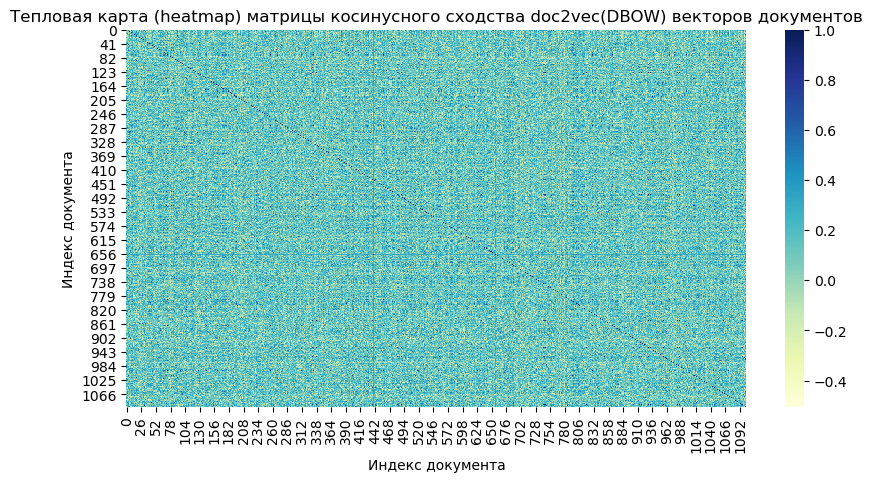

In [17]:
fig = plt.figure(figsize=(10,5),dpi=100)
sns.heatmap(cos, cmap="YlGnBu")
plt.title('Тепловая карта (heatmap) матрицы косинусного сходства doc2vec(DBOW) векторов документов')
plt.xlabel('Индекс документа')
plt.ylabel('Индекс документа')
plt.savefig('Тепловая карта (heatmap) матрицы косинусного сходства doc2vec(DBOW) векторов документов.png');

In [18]:
vec_15= [text_vectors_matrix[i] for i in range(15)]
cos_15 = cosine_similarity(vec_15, vec_15)
cos_15

array([[ 1.00000000e+00,  1.75009162e-01,  3.11860429e-01,
         3.05197049e-02,  1.02128588e-01,  1.98530838e-01,
        -1.70091554e-01,  6.96129279e-02,  3.52112815e-01,
         3.01803134e-02,  3.03986763e-01,  2.47739656e-01,
         6.70867754e-02,  2.86024745e-04,  2.92845968e-01],
       [ 1.75009162e-01,  1.00000000e+00,  5.45161114e-01,
         8.16333118e-02,  1.06490477e-01, -4.89131883e-02,
         1.14725653e-01,  1.74760365e-01,  1.50452106e-01,
         4.96138990e-01,  3.96535109e-01,  2.83042486e-01,
         2.64558112e-01,  1.02013654e-01,  2.36310436e-01],
       [ 3.11860429e-01,  5.45161114e-01,  1.00000000e+00,
         6.30205043e-02,  5.79737591e-03,  2.04870318e-01,
         9.31449217e-02,  2.58935765e-01,  1.34061353e-01,
         1.80847194e-01,  4.78458065e-01,  3.98181462e-01,
         5.02383396e-01, -4.76986961e-02,  2.23335122e-01],
       [ 3.05197049e-02,  8.16333118e-02,  6.30205043e-02,
         1.00000000e+00,  3.22943740e-01,  2.43750256

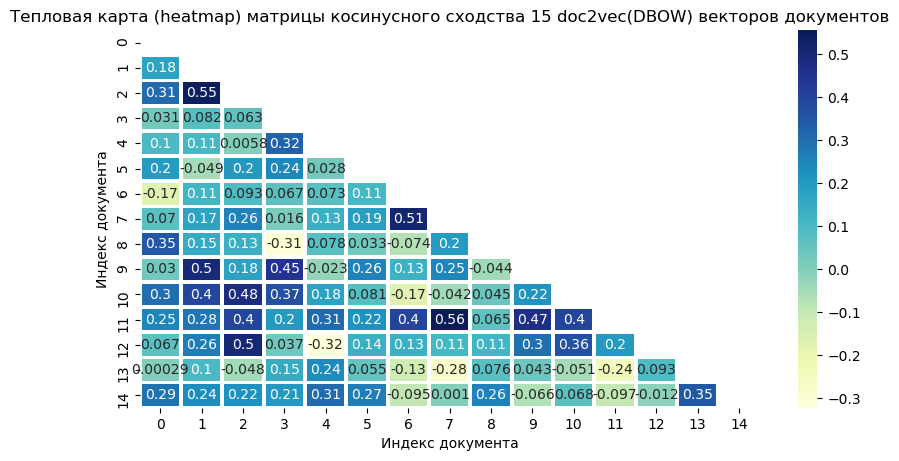

In [22]:
fig = plt.figure(figsize=(10,5),dpi=100)
matrix = np.triu(cos_15)
sns.heatmap(cos_15, cmap="YlGnBu", mask=matrix, annot=True, linewidths=2)
plt.title('Тепловая карта (heatmap) матрицы косинусного сходства 15 doc2vec(DBOW) векторов документов')
plt.xlabel('Индекс документа')
plt.ylabel('Индекс документа')
plt.savefig('Тепловая карта (heatmap) матрицы косинусного сходства 15 doc2vec(DBOW) векторов документов.png');

<Figure size 1000x500 with 0 Axes>

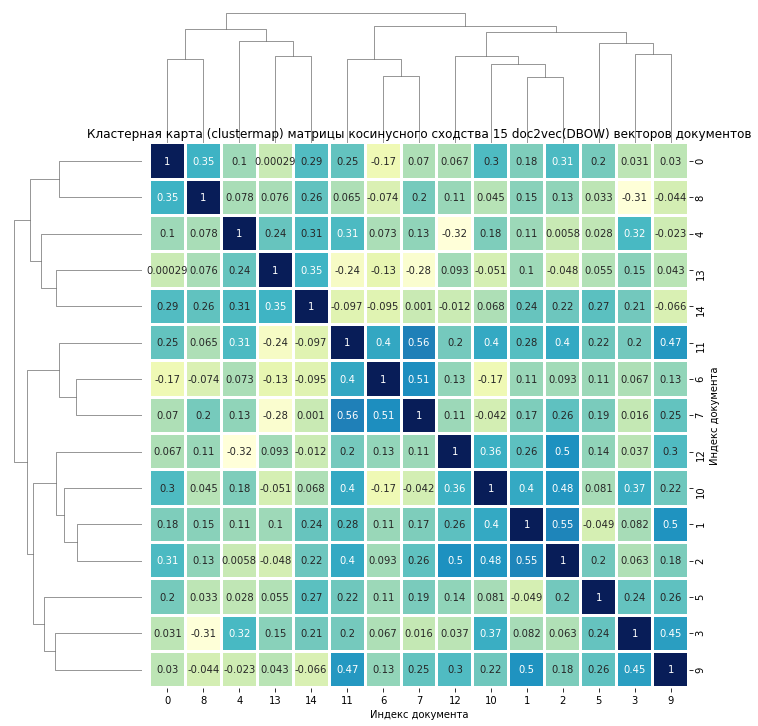

In [23]:
fig = plt.figure(figsize=(10,5),dpi=100)
sns.clustermap(cos_15, cmap="YlGnBu", annot=True, linewidths=2, cbar_pos=None)
plt.title('Кластерная карта (clustermap) матрицы косинусного сходства 15 doc2vec(DBOW) векторов документов')
plt.xlabel('Индекс документа')
plt.ylabel('Индекс документа')
plt.savefig('Кластерная карта (clustermap) матрицы косинусного сходства 15 doc2vec(DBOW) векторов документов.png');

<Figure size 1000x500 with 0 Axes>

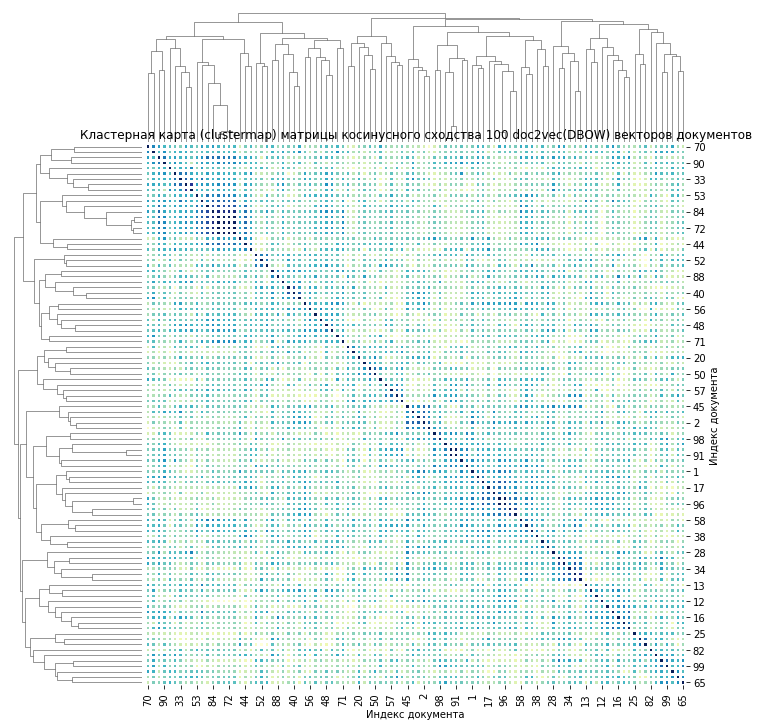

In [24]:
fig = plt.figure(figsize=(10,5),dpi=100)
vec_100= [text_vectors_matrix[i] for i in range(100)]
cos_100 = cosine_similarity(vec_100, vec_100)
cmap = sns.clustermap(cos_100, cmap="YlGnBu", linewidths=2, cbar_pos=None)
plt.title('Кластерная карта (clustermap) матрицы косинусного сходства 100 doc2vec(DBOW) векторов документов')
plt.xlabel('Индекс документа')
plt.ylabel('Индекс документа')
plt.savefig('Кластерная карта (clustermap) матрицы косинусного сходства 100 doc2vec(DBOW) векторов документов.png');

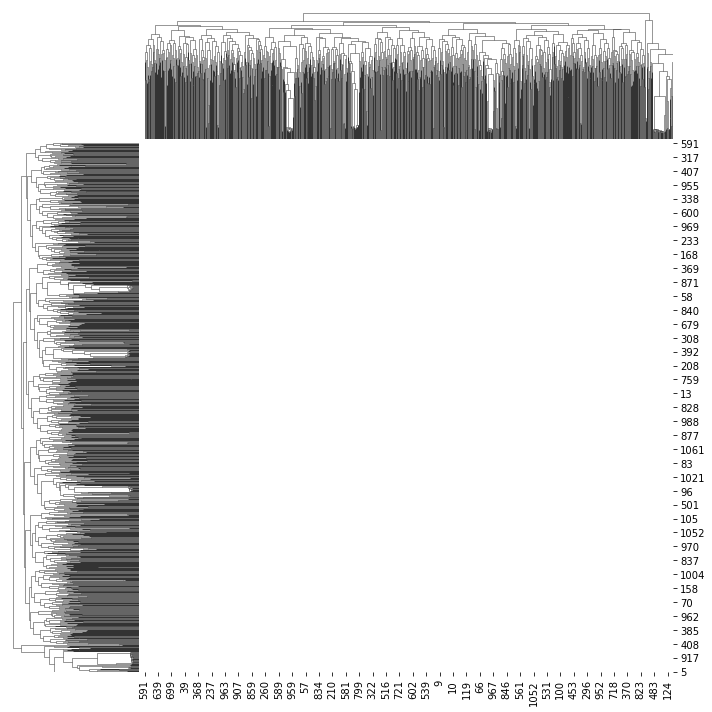

In [25]:
sns.clustermap(cos, cmap="YlGnBu", linewidths=2, cbar_pos=None)

### tsne

In [20]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
text_vectors_matrix_2d = tsne.fit_transform(text_vectors_matrix)
print("text_vectors_matrix_2d shape is ", text_vectors_matrix_2d.shape)

text_vectors_matrix_2d shape is  (1104, 2)


In [21]:
points_text = pd.DataFrame(
    [
        (text, coords[0], coords[1]) 
        for text, coords in [
            (text, text_vectors_matrix_2d[text_list.index(text)])
            for text in text_list
        ]
    ],
    columns=["text", "x", "y"]
)

In [17]:
points_text

,text,x,y
0,связь правило высокий стоимость имущество пере...,-1.807302,-8.136451
1,быть правительство брать обязанность выплачива...,-17.347912,-13.405748
2,затем потребоваться снять крупный сумма начать...,-4.811471,-5.369548
3,каждый фирма рубрика услуга микрофинансировани...,-11.617148,11.394958
4,минимальный пакет документ минимальный_пакет п...,-22.144745,26.106327
...,...,...,...
1099,наш фирма лидер рынок свой область наш_фирма ф...,21.214798,3.713078
1100,получение заём клиент должный предоставить мин...,-9.070510,11.763996
1101,поставка оборудование эквайринг предоставление...,2.282775,-8.111555
1102,случай непредставление соответствующий докумен...,2.518671,-10.736423


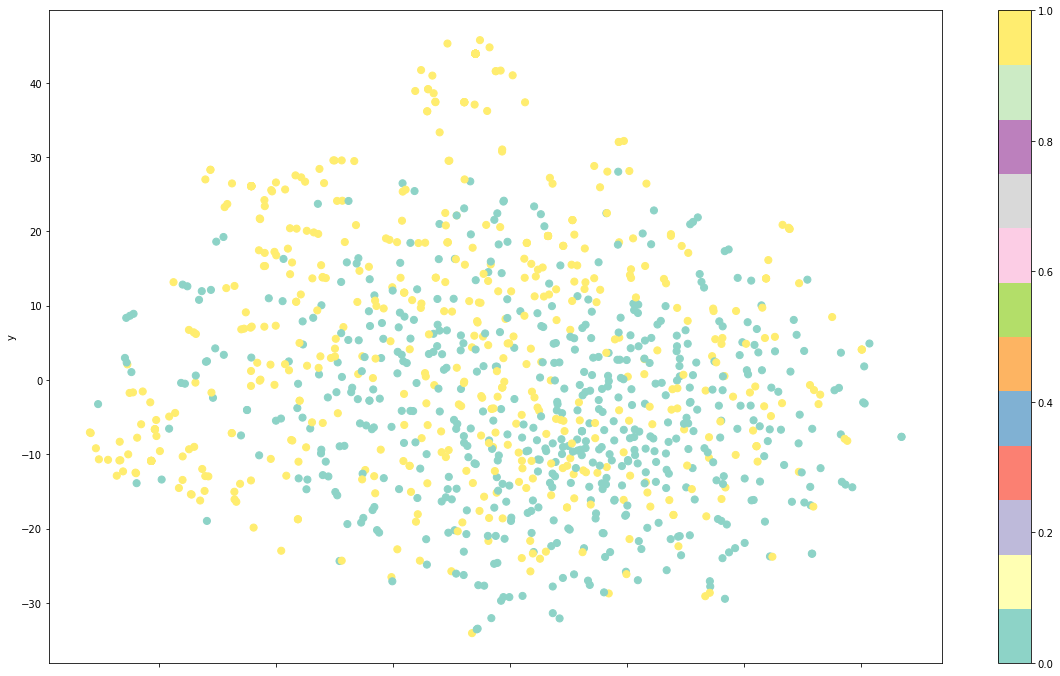

In [18]:
points_text.plot.scatter("x", "y", s=50, figsize=(20, 12), c=df['label'], colormap='Set3')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('doc2vec_dbow_vectors_full_texts.png');

## 3. Классификация с помощью SVM только на векторах текстов

### 3.1. Данные для обучения

In [15]:
X = pd.DataFrame(text_vectors_matrix)
y = df['label']

In [16]:
X

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.209621,0.160664,-0.227712,-0.014728,-0.087732,0.112420,-0.079169,-0.060038,0.041512,-0.197862,...,0.067748,0.006171,-0.040276,0.028087,-0.065688,0.199895,0.085324,-0.034946,-0.035606,0.049931
1,-0.062047,0.203249,0.175047,0.045313,-0.053759,0.152499,-0.269174,0.023960,0.050811,-0.021293,...,-0.015760,-0.136418,-0.050018,-0.148565,0.037667,0.147375,-0.021406,0.254064,-0.036809,-0.227201
2,-0.069630,0.076268,-0.254178,-0.041058,0.033597,0.011057,0.007965,0.038274,0.141236,-0.048149,...,0.044432,-0.014124,0.077134,-0.006457,-0.012709,0.074994,0.009044,0.173819,0.135646,-0.097169
3,-0.047489,-0.009814,-0.252301,0.100205,0.061196,0.009278,0.296970,-0.091768,0.200771,-0.108269,...,-0.073058,-0.020296,0.189792,-0.150367,-0.329817,-0.126813,0.157353,0.005373,-0.130984,0.132044
4,-0.055820,0.198748,0.231292,0.170294,-0.152597,0.065645,0.131594,-0.152130,0.130236,-0.303719,...,-0.052511,-0.221327,0.282842,-0.175470,-0.334658,0.312803,-0.124916,0.335329,-0.287697,-0.123464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.213687,-0.305274,-0.063454,0.048019,-0.087133,-0.000074,0.150120,-0.190685,0.002543,-0.068245,...,0.106970,-0.040670,-0.050291,-0.186181,-0.151440,-0.107320,0.231616,-0.082298,0.093584,-0.142312
1100,-0.108991,-0.021799,-0.309175,-0.088114,-0.015036,0.046301,0.196665,0.032078,-0.120690,-0.041673,...,-0.018747,0.085432,0.159975,-0.093418,-0.293402,0.064452,0.087152,-0.035780,-0.042505,-0.014878
1101,-0.319666,0.349897,-0.251391,0.174723,0.003103,0.125779,-0.004981,-0.099209,0.269269,-0.316596,...,0.113506,0.035622,-0.056864,0.136984,0.021936,-0.043798,0.186607,-0.083108,0.051603,0.345864
1102,-0.085740,0.289907,-0.113477,-0.042349,0.036586,0.012504,-0.059479,0.038323,-0.000148,-0.226456,...,-0.120726,-0.077754,-0.028411,0.129245,0.006419,0.070481,0.070483,0.109285,-0.158134,0.068361


In [17]:
y

0       0
1       0
2       0
3       0
4       1
       ..
1099    0
1100    1
1101    0
1102    0
1103    1
Name: label, Length: 1104, dtype: int64

### 3.2. SVM + GridSearchCV

In [19]:
param_grid =[{'kernel': ['linear'], 
               'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
             
             {'kernel': ['rbf'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001]} ]


#{'kernel': ['poly'],  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'degree':[0, 1, 2, 3, 4, 5]}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)


In [42]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = RepeatedStratifiedKFold(10,3), n_jobs=-1, 
                    return_train_score=True, scoring='f1')
grid.fit(X_train, y_train)


Fitting 50 folds for each of 49 candidates, totalling 2450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2450 out of 2450 | elapsed:  3.9min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=None),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='f1', verbose=3)

In [43]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)


In [44]:
results = pd.DataFrame(grid.cv_results_)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split42_train_score,split43_train_score,split44_train_score,split45_train_score,split46_train_score,split47_train_score,split48_train_score,split49_train_score,mean_train_score,std_train_score
0,0.219290,0.029005,0.025838,0.002750,0.001,linear,NaN,"{'C': 0.001, 'kernel': 'linear'}",0.000000,0.093023,...,0.010695,0.016000,0.016000,0.010724,0.005376,0.005376,0.010695,0.016000,0.014879,0.011568
1,0.164851,0.003481,0.021014,0.000701,0.01,linear,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.789474,0.696970,...,0.748092,0.754947,0.742331,0.727838,0.743472,0.733333,0.743902,0.742681,0.740995,0.009286
2,0.137340,0.004379,0.016407,0.000495,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.790123,0.724638,...,0.784703,0.792666,0.783593,0.786014,0.788652,0.785414,0.794366,0.787024,0.786880,0.006846
3,0.142371,0.003536,0.014475,0.000536,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.784810,0.756757,...,0.802213,0.809986,0.803894,0.816438,0.822888,0.813793,0.813278,0.791608,0.810057,0.007459
4,0.269266,0.016493,0.013928,0.000851,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.734177,0.837838,...,0.811034,0.824658,0.802817,0.825613,0.826087,0.819807,0.822715,0.801664,0.818481,0.007408
5,1.365677,0.202678,0.013990,0.001086,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.769231,0.826667,...,0.837466,0.859917,0.826816,0.851182,0.849582,0.859116,0.840336,0.832630,0.845155,0.008148
6,16.700458,3.436473,0.014105,0.000484,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.795181,0.769231,...,0.882834,0.886457,0.878581,0.893387,0.878581,0.880000,0.874659,0.871233,0.879550,0.006802
7,0.207089,0.007255,0.026841,0.001766,0.001,rbf,10,"{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.206741,0.003832,0.026532,0.000986,0.001,rbf,1,"{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.213562,0.006103,0.027372,0.001045,0.001,rbf,0.1,"{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


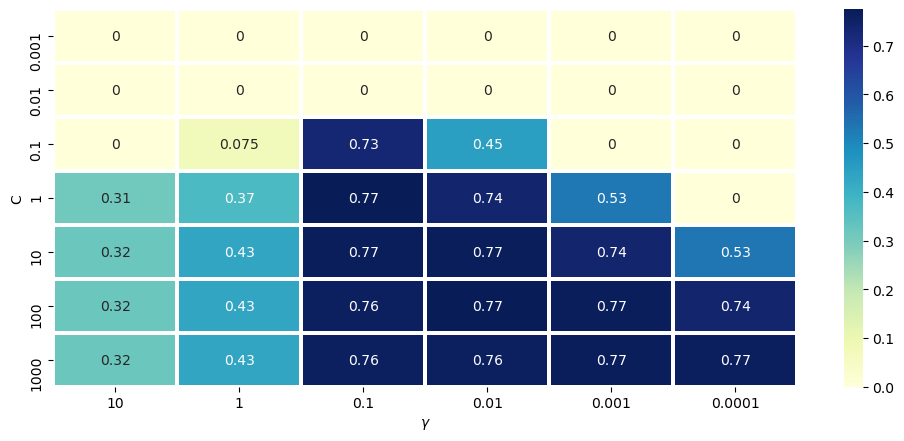

In [45]:
x1 = 10, 1, 0.1, 0.01, 0.001, 0.0001
y1 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
scores_rbf = np.array(results[results.param_kernel=='rbf'].mean_test_score).reshape(7,6)

fig = plt.figure(figsize=(12, 5), dpi=100)
sns.heatmap(scores_rbf, cmap="YlGnBu", annot=True, linewidths=2, xticklabels=x1, yticklabels=y1)
plt.xlabel("$\gamma$")
plt.ylabel("C")
plt.savefig("d2v_dbow_heatmap_rbf.png")

In [46]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(grid.best_estimator_, X, y, "C",[0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=10)

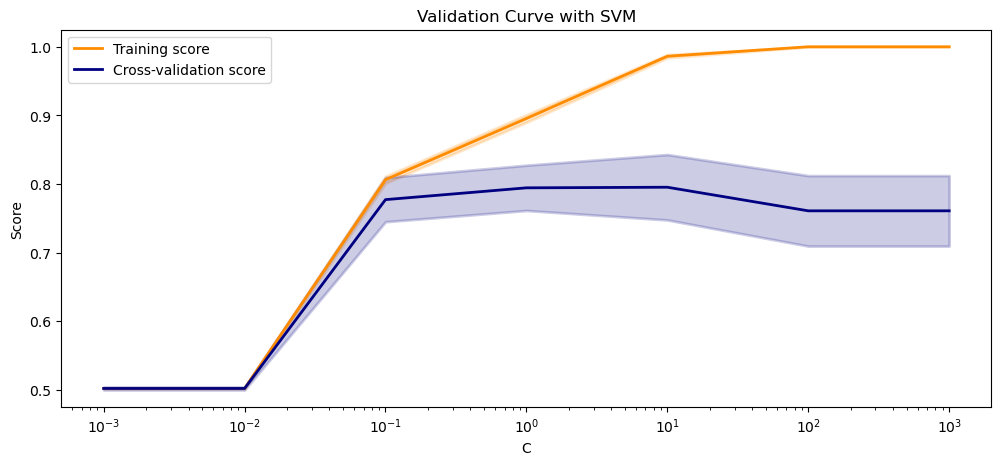

In [47]:
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


fig = plt.figure(figsize=(12, 5), dpi=100)
plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [48]:
train_scores, valid_scores = validation_curve(grid.best_estimator_, X, y, "gamma",[10, 1, 0.1, 0.01, 0.001, 0.0001], cv=10)

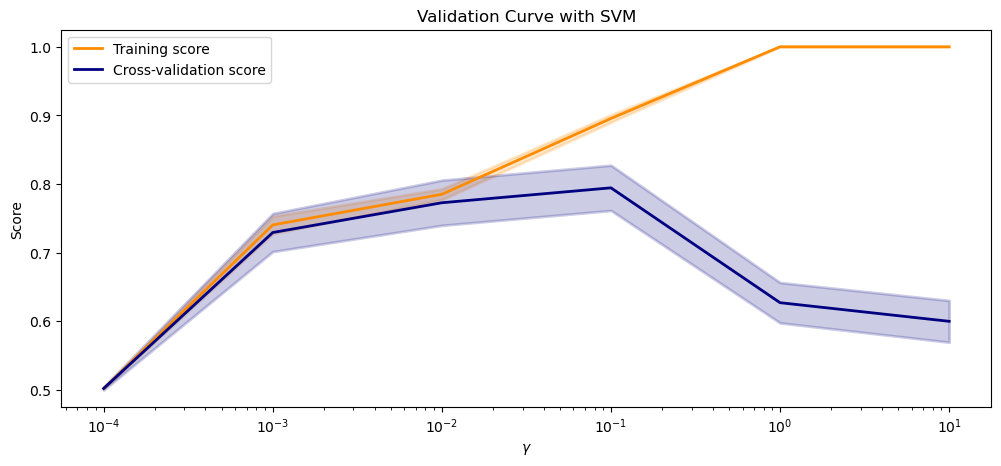

In [49]:
param_range = [10, 1, 0.1, 0.01, 0.001, 0.0001]
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


fig = plt.figure(figsize=(12, 5), dpi=100)
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [60]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       135
           1       0.82      0.79      0.81       141

    accuracy                           0.80       276
   macro avg       0.80      0.80      0.80       276
weighted avg       0.80      0.80      0.80       276



In [61]:
print ('Accuracy (test)=', metrics.accuracy_score(y_test, grid_predictions))
print ('Precision(test) =', metrics.precision_score(y_test, grid_predictions))
print ('Recall(test) =', metrics.recall_score(y_test, grid_predictions))
print ('F1-score (test)=', metrics.f1_score(y_test, grid_predictions))

Accuracy (test)= 0.8043478260869565
Precision(test) = 0.8175182481751825
Recall(test) = 0.7943262411347518
F1-score (test)= 0.8057553956834532


In [62]:
clf = grid.best_estimator_
pred_train = clf.predict(X_train)
print ('Accuracy (train)=', metrics.accuracy_score(y_train, pred_train))
print ('Precision(train) =', metrics.precision_score(y_train, pred_train))
print ('Recall (train)=', metrics.recall_score(y_train, pred_train))
print ('F1-score (train) =', metrics.f1_score(y_train, pred_train))

Accuracy (train)= 0.892512077294686
Precision(train) = 0.9263157894736842
Recall (train)= 0.8523002421307506
F1-score (train) = 0.8877679697351829


In [63]:
#сохранение полученного классификатора 
joblib.dump(grid.best_estimator_, 'd2v_dbow_SVM.pkl')

['d2v_dbow_SVM.pkl']

In [64]:
scores_acc = cross_val_score(grid.best_estimator_, X, y, cv=10, scoring = 'accuracy')
scores_pre = cross_val_score(grid.best_estimator_, X, y, cv=10, scoring = 'precision')
scores_re = cross_val_score(grid.best_estimator_, X, y, cv=10, scoring = 'recall')
scores_f = cross_val_score(grid.best_estimator_, X, y, cv=10, scoring = 'f1')

In [65]:
print('Accuracy')
print(scores_acc)
print(np.mean(scores_acc))

print('Precision')
print(scores_pre)
print(np.mean(scores_pre))


print('Recall')
print(scores_re)
print(np.mean(scores_re))

print('F1')
print(scores_f)
print(np.mean(scores_f))

Accuracy
[0.83783784 0.84684685 0.78378378 0.77477477 0.78181818 0.74545455
 0.81818182 0.74545455 0.8        0.80909091]
0.7943243243243243
Precision
[0.83928571 0.95348837 0.83333333 0.78181818 0.79245283 0.75471698
 0.87234043 0.75471698 0.81132075 0.84      ]
0.823347357423198
Recall
[0.83928571 0.73214286 0.71428571 0.76785714 0.76363636 0.72727273
 0.74545455 0.72727273 0.78181818 0.76363636]
0.7562662337662338
F1
[0.83928571 0.82828283 0.76923077 0.77477477 0.77777778 0.74074074
 0.80392157 0.74074074 0.7962963  0.8       ]
0.7871051210757093


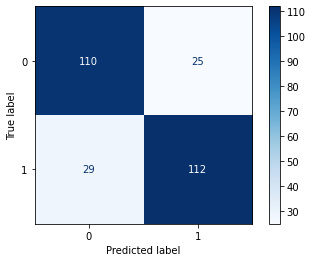

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, grid_predictions)

cm_display = ConfusionMatrixDisplay(cm).plot(cmap = 'Blues')
plt.savefig('d2v_dbow_svm_conf_matrix.png')


In [67]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

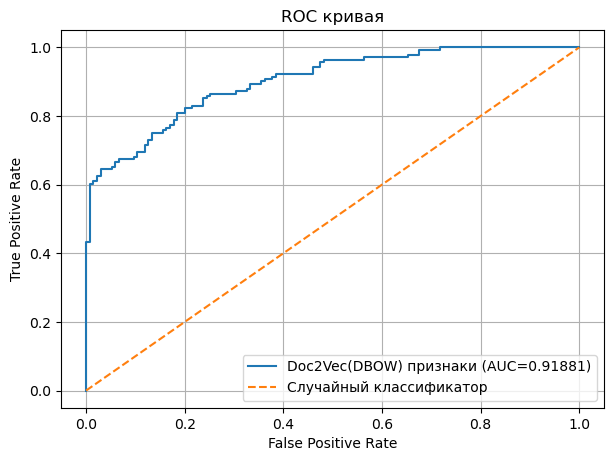

In [68]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

fpr, tpr, _ = roc_curve(y_test, clf.decision_function(X_test))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name='Doc2Vec(DBOW) признаки (AUC={0:0.5f})'.format(average_precision_score(y_test, clf.decision_function(X_test))))
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайный классификатор')
plt.legend()
plt.title("ROC кривая")
plt.grid()
plt.savefig('d2v_dbow_roc_curve.png')

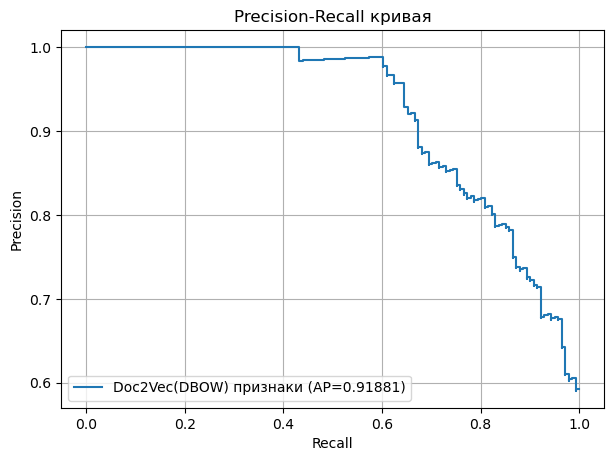

In [73]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

prec, recall, _ = precision_recall_curve(y_test, clf.decision_function(X_test))
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax, name='Doc2Vec(DBOW) признаки (AP={0:0.5f})'.format(average_precision_score(y_test, clf.decision_function(X_test))))

plt.title("Precision-Recall кривая")
plt.grid();
plt.savefig('d2v_dbow_pr_curve.png')

In [74]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, grid_predictions)

0.6090130918588842

In [75]:
X.to_csv("Doc2Vec_DBOW_vectors.csv",index=False)


## 4. Классификация на векторах текстов с дополнительными признаками на основе URL

### 4.1. Данные для обучения с дополнительными признаками

In [18]:
df_add = pd.read_csv('additional_features_norm.csv')

In [19]:
df_add

,whois_regDate,whois_expDate,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,protocol,protocol_count
0,-0.839701,-0.789207,-1.000000,-1.0,-0.790660,-1.000000,-1.0,-0.655172,-1.0,-0.666667,1.0,-1.0
1,-0.530498,-0.871061,-1.000000,-1.0,-0.764895,-1.000000,-1.0,-0.586207,-1.0,-0.666667,1.0,-1.0
2,-0.337393,-0.789207,-0.834471,-1.0,-0.864734,-0.984252,-1.0,-0.724138,-1.0,-0.666667,1.0,-1.0
3,-0.538552,-0.841362,-1.000000,-0.6,-0.877617,-1.000000,-1.0,-1.000000,-1.0,-0.555556,1.0,-1.0
4,0.616934,-0.848606,-1.000000,-1.0,-0.913043,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1099,-0.538159,-0.842811,-0.634812,-0.6,-0.945250,-1.000000,-1.0,-0.931034,-1.0,-0.888889,1.0,-1.0
1100,0.616934,-0.848606,-1.000000,-1.0,-0.896940,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
1101,-0.293390,-0.951467,-1.000000,-1.0,-0.919485,-0.952756,-1.0,-1.000000,-1.0,-0.666667,1.0,-1.0
1102,-0.509478,-0.948569,-1.000000,-1.0,-0.909823,-1.000000,-1.0,-0.931034,-1.0,-0.666667,1.0,-1.0


In [20]:
X_new = X.join(df_add)

In [21]:
X_new

,0,1,2,3,4,5,6,7,8,9,...,whois_updatedDate,dot_count,url_len,digit_count,special_count,hyphen_count,double_slash,single_slash,protocol,protocol_count
0,-0.209621,0.160664,-0.227712,-0.014728,-0.087732,0.112420,-0.079169,-0.060038,0.041512,-0.197862,...,-1.000000,-1.0,-0.790660,-1.000000,-1.0,-0.655172,-1.0,-0.666667,1.0,-1.0
1,-0.062047,0.203249,0.175047,0.045313,-0.053759,0.152499,-0.269174,0.023960,0.050811,-0.021293,...,-1.000000,-1.0,-0.764895,-1.000000,-1.0,-0.586207,-1.0,-0.666667,1.0,-1.0
2,-0.069630,0.076268,-0.254178,-0.041058,0.033597,0.011057,0.007965,0.038274,0.141236,-0.048149,...,-0.834471,-1.0,-0.864734,-0.984252,-1.0,-0.724138,-1.0,-0.666667,1.0,-1.0
3,-0.047489,-0.009814,-0.252301,0.100205,0.061196,0.009278,0.296970,-0.091768,0.200771,-0.108269,...,-1.000000,-0.6,-0.877617,-1.000000,-1.0,-1.000000,-1.0,-0.555556,1.0,-1.0
4,-0.055820,0.198748,0.231292,0.170294,-0.152597,0.065645,0.131594,-0.152130,0.130236,-0.303719,...,-1.000000,-1.0,-0.913043,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.213687,-0.305274,-0.063454,0.048019,-0.087133,-0.000074,0.150120,-0.190685,0.002543,-0.068245,...,-0.634812,-0.6,-0.945250,-1.000000,-1.0,-0.931034,-1.0,-0.888889,1.0,-1.0
1100,-0.108991,-0.021799,-0.309175,-0.088114,-0.015036,0.046301,0.196665,0.032078,-0.120690,-0.041673,...,-1.000000,-1.0,-0.896940,-0.889764,-1.0,-1.000000,-1.0,-0.666667,-1.0,-1.0
1101,-0.319666,0.349897,-0.251391,0.174723,0.003103,0.125779,-0.004981,-0.099209,0.269269,-0.316596,...,-1.000000,-1.0,-0.919485,-0.952756,-1.0,-1.000000,-1.0,-0.666667,1.0,-1.0
1102,-0.085740,0.289907,-0.113477,-0.042349,0.036586,0.012504,-0.059479,0.038323,-0.000148,-0.226456,...,-1.000000,-1.0,-0.909823,-1.000000,-1.0,-0.931034,-1.0,-0.666667,1.0,-1.0


### 4.3. Подбор параметров 

In [22]:
param_grid =[{'kernel': ['linear'], 
               'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
             
             {'kernel': ['rbf'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001]} ]


#{'kernel': ['poly'],  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'degree':[0, 1, 2, 3, 4, 5]}

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_new, y, test_size = 0.25, random_state = 101)

In [23]:
%%time 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv = RepeatedStratifiedKFold(10,3), n_jobs=-1, 
                    return_train_score=True, scoring='f1')
grid.fit(X_train1, y_train1)

Fitting 30 folds for each of 49 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed:  1.1min finished


CPU times: user 2.65 s, sys: 386 ms, total: 3.03 s
Wall time: 1min 7s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='f1', verbose=3)

In [24]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1)


In [123]:
results = pd.DataFrame(grid.cv_results_)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
0,0.234421,0.030150,0.028324,0.006263,0.001,linear,NaN,"{'C': 0.001, 'kernel': 'linear'}",0.906667,0.948718,...,0.932568,0.935622,0.937143,0.936963,0.935438,0.932374,0.935622,0.935622,0.934185,0.003094
1,0.099308,0.007610,0.012224,0.000548,0.01,linear,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.906667,0.948718,...,0.932568,0.935622,0.937143,0.936963,0.935438,0.932374,0.935622,0.935622,0.934185,0.003094
2,0.056611,0.003950,0.008761,0.001041,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.906667,0.948718,...,0.932568,0.935622,0.937143,0.936963,0.935438,0.932374,0.935622,0.935622,0.934185,0.003094
3,0.052753,0.003958,0.007982,0.000453,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.935065,0.913580,...,0.968363,0.965706,0.972452,0.973793,0.971114,0.966667,0.966851,0.975207,0.969811,0.002672
4,0.080170,0.011244,0.008139,0.001465,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.936709,0.902439,...,0.975477,0.976808,0.979424,0.982313,0.978082,0.971193,0.979480,0.979536,0.978008,0.002990
5,0.202166,0.041408,0.007295,0.000951,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.936709,0.904762,...,0.989130,0.986450,0.989160,0.989160,0.990502,0.982265,0.990528,0.990502,0.988143,0.002798
6,0.499056,0.138203,0.007302,0.000620,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.938272,0.876404,...,1.000000,0.998654,1.000000,1.000000,0.998650,1.000000,1.000000,1.000000,0.999596,0.000617
7,0.217088,0.006241,0.027372,0.001254,0.001,rbf,10,"{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.226504,0.011671,0.028530,0.002411,0.001,rbf,1,"{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.220712,0.004421,0.028051,0.002490,0.001,rbf,0.1,"{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


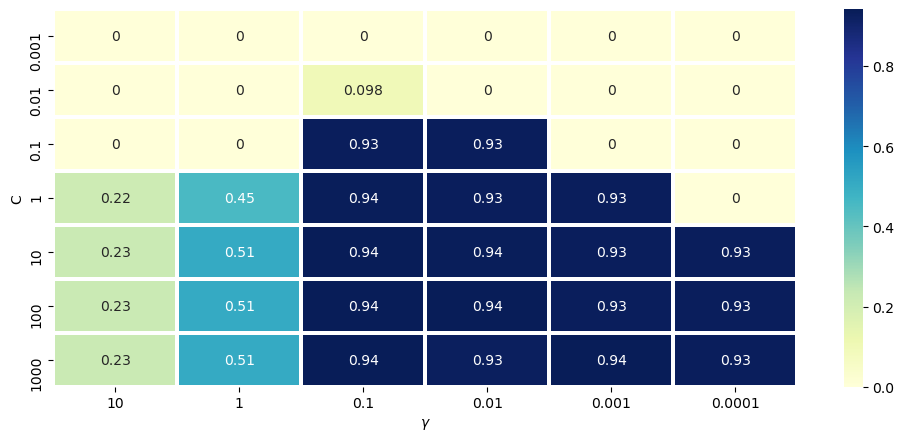

In [138]:
x1 = [10, 1, 0.1, 0.01, 0.001, 0.0001]
y1 = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
scores_rbf = np.array(results[results.param_kernel=='rbf'].mean_test_score).reshape(7,6)

fig = plt.figure(figsize=(12, 5), dpi=100)
sns.heatmap(scores_rbf, cmap="YlGnBu", annot=True, linewidths=2, xticklabels=x1, yticklabels=y1)
plt.xlabel("$\gamma$")
plt.ylabel("C")
plt.savefig("d2v_dbow_addFeatures_heatmap_rbf.png")

In [125]:
train_scores, valid_scores = validation_curve(grid.best_estimator_, X_new, y, "C",[0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=10)

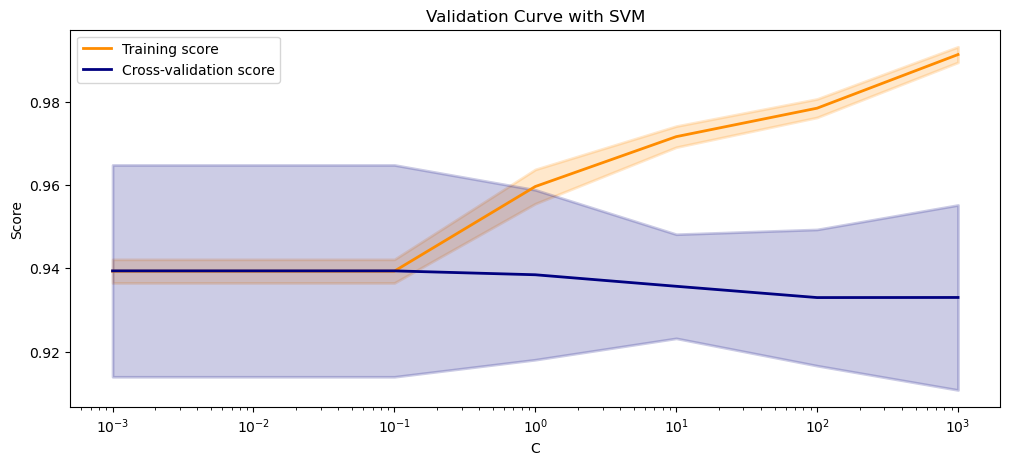

In [126]:
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


fig = plt.figure(figsize=(12, 5), dpi=100)
plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [111]:
train_scores, valid_scores = validation_curve(grid.best_estimator_, X_new, y, "gamma",[10, 1, 0.1, 0.01, 0.001, 0.0001], cv=10)

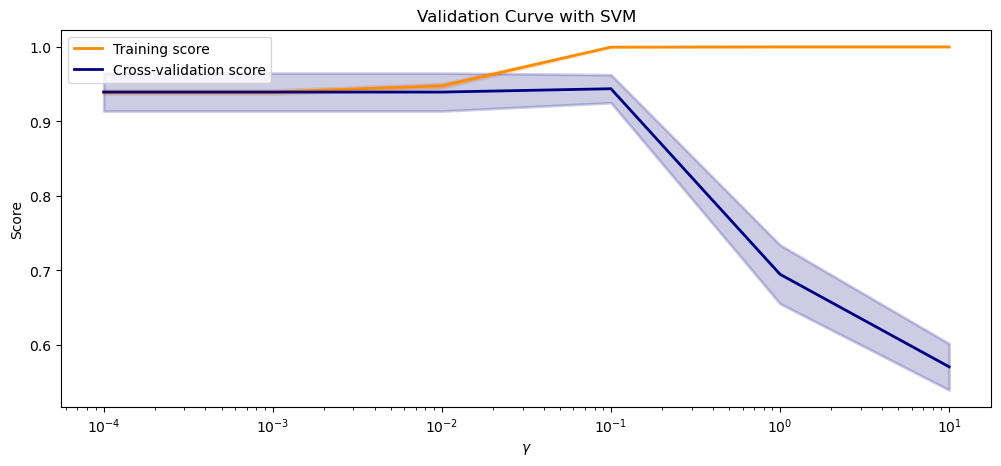

In [112]:
param_range = [10, 1, 0.1, 0.01, 0.001, 0.0001]
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


fig = plt.figure(figsize=(12, 5), dpi=100)
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [29]:
new_grid_predictions = grid.predict(X_test1)
print(metrics.classification_report(y_test1, new_grid_predictions))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       135
           1       0.96      0.92      0.94       141

    accuracy                           0.94       276
   macro avg       0.94      0.94      0.94       276
weighted avg       0.94      0.94      0.94       276



In [119]:
print ('Accuracy (test) =', metrics.accuracy_score(y_test1, new_grid_predictions))
print ('Precision (test)=', metrics.precision_score(y_test1, new_grid_predictions))
print ('Recall (test) =', metrics.recall_score(y_test1, new_grid_predictions))
print ('F1-score(test) =', metrics.f1_score(y_test1, new_grid_predictions))

Accuracy (test) = 0.9347826086956522
Precision (test)= 0.948905109489051
Recall (test) = 0.9219858156028369
F1-score(test) = 0.935251798561151


In [120]:
clf1 = grid.best_estimator_
pred_train = clf1.predict(X_train1)
print ('Accuracy (train)=', metrics.accuracy_score(y_train1, pred_train))
print ('Precision(train) =', metrics.precision_score(y_train1, pred_train))
print ('Recall (train)=', metrics.recall_score(y_train1, pred_train))
print ('F1-score (train) =', metrics.f1_score(y_train1, pred_train))

Accuracy (train)= 1.0
Precision(train) = 1.0
Recall (train)= 1.0
F1-score (train) = 1.0


In [30]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test1, new_grid_predictions)

0.8849487785657998

In [28]:
#сохранение полученного классификатора 
joblib.dump(grid.best_estimator_, 'd2v_dbow_SVM_with_add_features.pkl')

['d2v_dbow_SVM_with_add_features.pkl']

In [103]:
scores_acc = cross_val_score(clf1, X_new, y, cv=10, scoring = 'accuracy')
scores_pre = cross_val_score(clf1, X_new, y, cv=10, scoring = 'precision')
scores_re = cross_val_score(clf1, X_new, y, cv=10, scoring = 'recall')
scores_f = cross_val_score(clf1, X_new, y, cv=10, scoring = 'f1')

In [104]:
print('Accuracy')
print(scores_acc)
print(np.mean(scores_acc))

print('Precision')
print(scores_pre)
print(np.mean(scores_pre))


print('Recall')
print(scores_re)
print(np.mean(scores_re))

print('F1')
print(scores_f)
print(np.mean(scores_f))

Accuracy
[0.92792793 0.94594595 0.96396396 0.90990991 0.96363636 0.95454545
 0.93636364 0.97272727 0.92727273 0.93636364]
0.9438656838656838
Precision
[0.98       1.         0.96428571 0.96       0.93220339 0.96296296
 0.96153846 0.98148148 0.97959184 0.96153846]
0.9683602308372284
Recall
[0.875      0.89285714 0.96428571 0.85714286 1.         0.94545455
 0.90909091 0.96363636 0.87272727 0.90909091]
0.9189285714285713
F1
[0.9245283  0.94339623 0.96428571 0.90566038 0.96491228 0.95412844
 0.93457944 0.97247706 0.92307692 0.93457944]
0.9421624206816599


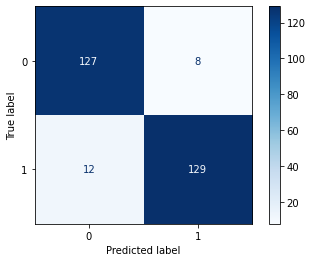

In [139]:
y_pred = clf1.predict(X_test1)
cm = confusion_matrix(y_test1, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.savefig('d2v_dbow_addFeatures_svm_conf_matrix.png')

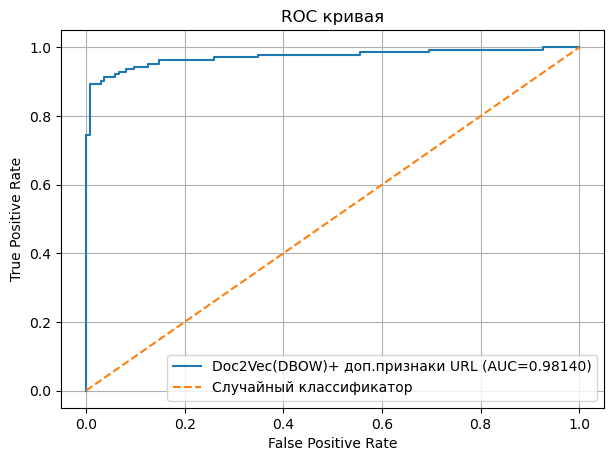

In [141]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

fpr, tpr, _ = roc_curve(y_test1, clf1.decision_function(X_test1))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name='Doc2Vec(DBOW)+ доп.признаки URL (AUC={0:0.5f})'.format(average_precision_score(y_test1, clf1.decision_function(X_test1))))
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайный классификатор')
plt.legend()
plt.title("ROC кривая")
plt.grid()
plt.savefig('d2v_dbow_addFeatures_roc_curve.png')

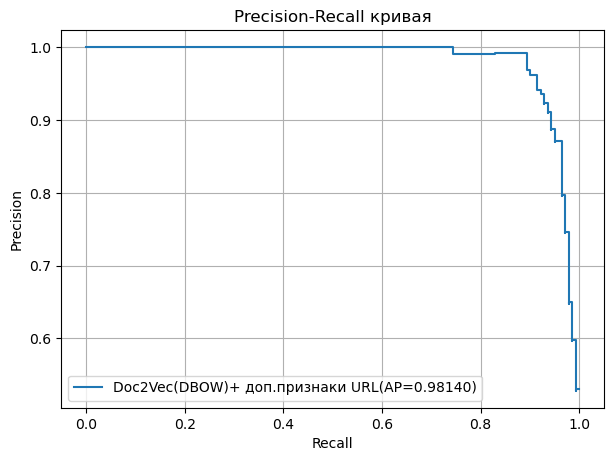

In [142]:
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

prec, recall, _ = precision_recall_curve(y_test, clf1.decision_function(X_test1))
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax, name='Doc2Vec(DBOW)+ доп.признаки URL(AP={0:0.5f})'.format(average_precision_score(y_test1, clf1.decision_function(X_test1))))

plt.title("Precision-Recall кривая")
plt.grid();
plt.savefig('d2v_dbow_addFeatures_pr_curve.png')

In [ ]:
X_new.to_csv("Doc2Vec_DBOW_vectors_withAddFeatures.csv",index=False)